In [1]:
# Import required modules
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import requests
from LeXmo import LeXmo
from preprocessing import processing
import pickle
import os
from tqdm.notebook import tqdm
import statsmodels.formula.api as sm
from scipy.stats import t 
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
sp = "sp600" # sp500 or sp600

In [3]:
df_path = "data/df_final_"+sp    ##############CHANGE
# df_path = "data/df_final"
with open(df_path,"rb") as file :
    df_final = pickle.load(file)

In [4]:
display(df_final)

,id,date,ticker,text,earning_call_quarter
26,4260232,2019-05-05,AAT,Question-and-Answer Session\n \nOperator\n \n[...,2019Q1
27,4281104,2019-08-02,AAT,Question-and-Answer Session\n \nOperator\n \nT...,2019Q2
28,4301865,2019-11-03,AAT,Question-and-Answer Session\n \nOperator\n \nT...,2019Q3
29,4323613,2020-02-12,AAT,Question-and-Answer Session\n \nOperator\n \nT...,2019Q4
30,4341190,2020-04-29,AAT,Question-and-Answer Session\n \nOperator\n \nT...,2020Q1
...,...,...,...,...,...
1892,4420401,2021-04-21,PFBC,Question-and-Answer Session\n \nOperator\n \n[...,2021Q1
1893,4440488,2021-07-21,PFBC,Question-and-Answer Session\n \nOperator\n \nT...,2021Q2
1894,4461252,2021-10-21,PFBC,Question-and-Answer Session\n \nOperator\n \n[...,2021Q3
1895,4480666,2022-01-20,PFBC,Question-and-Answer Session\n \nOperator\n \nT...,2021Q4


# Import datas from yahoo finance

In [5]:
# Get the month from which we import stock returns :
    # Q1 : from january (1) to march (3)
    # Q2 : from april (4) to june (6)
    # Q3 : from july (7) to septmber (9)
    # Q4 : from october (10) to december (12)

#df_final['earning_call_quarter'] = pd.to_datetime(df_final['earning_call_quarter'])
df_final['date'] = pd.to_datetime(df_final['date'])

# Quarters start 1 end
quarter_start = df_final['earning_call_quarter'].iloc[0].quarter
quarter_end = df_final['earning_call_quarter'].iloc[-1].quarter 

# Months start 1 end
month_start = quarter_start*2-1
month_end = quarter_end*3

# Day end : 30 or 31 ?
if month_end in [3,12]:
    day_end = 31
else:
    day_end = 30


In [6]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

# Take a margin of 1 year to calculate abnormal returns
start = datetime.datetime(df_final['earning_call_quarter'].iloc[0].year-1,month_start,2)
end   = datetime.datetime(df_final['earning_call_quarter'].iloc[-1].year+1,month_end,day_end)

# Create empty dataframe
stock_final = pd.DataFrame()

# Iterate over each symbol
list_tickers = list(set(list(df_final['ticker'])))
for i in list_tickers:  
    
    # print the symbol which is being downloaded
    print( str(list_tickers.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['ticker']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
        
display(stock_final)

0 : PARR,1 : CHRS,2 : CCS,3 : AHH,4 : ALRM,5 : AMWD,6 : ANIP,7 : ARLO,8 : COLL,9 : ASTE,10 : CLB,11 : PBH,12 : AX,13 : BKE,14 : BCOR,15 : AVA,16 : CHUY,17 : AIT,18 : AEIS,19 : BMI,20 : CENX,21 : AEL,22 : CELH,23 : BGS,24 : BCC,25 : CCOI,26 : AMCX,27 : BRC,28 : AOSL,29 : AIN,30 : ARI,31 : ABG,32 : ADC,33 : PFBC,34 : ACA,35 : BANR,36 : CASH,37 : AGO,38 : CSGS,39 : CHEF,40 : BCPC,41 : CAL,42 : PBI,43 : CEIX,44 : CAMP,45 : AVNS,46 : CPSI,47 : PAHC,48 : CNXN,49 : ATNI,50 : ATI,51 : BDN,52 : CAKE,53 : ASIX,54 : BKU,55 : ALEX,56 : BSIG,57 : ADTN,58 : CBU,59 : APOG,60 : CARA,61 : CCRN,62 : B,63 : AXL,64 : BRKL,65 : CMP,66 : ANDE,67 : ATGE,68 : BOOT,69 : CEVA,70 : AVD,71 : CLDT,72 : BJRI,73 : AAWW,74 : AKR,75 : PDFS,76 : BOOM,77 : AWR,78 : PETS,79 : ABCB,80 : CHCT,81 : ARCB,82 : BBBY,83 : PBF,84 : APEI,85 : AAT,86 : CRMT,87 : BANC,88 : BIG,89 : AMBC,90 : BLFS,91 : AGYS,92 : ACLS,93 : AMSF,94 : ALG,95 : ANF,96 : ALGT,97 : ANGO,98 : BLMN,99 : CENT,

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2018-01-02,19.379999,19.670000,19.240000,19.620001,19.620001,611900,PARR
2018-01-03,19.650000,19.840000,19.080000,19.100000,19.100000,235200,PARR
2018-01-04,19.299999,19.299999,18.959999,19.100000,19.100000,201600,PARR
2018-01-05,19.020000,19.040001,18.750000,18.830000,18.830000,145300,PARR
2018-01-08,18.830000,19.049999,18.780001,18.990000,18.990000,166000,PARR
...,...,...,...,...,...,...,...
2022-06-06,45.090000,45.189999,44.720001,45.049999,45.049999,27000,CENT
2022-06-07,44.650002,45.230000,44.570000,44.900002,44.900002,25500,CENT
2022-06-08,44.860001,44.860001,42.970001,43.959999,43.959999,60700,CENT


In [7]:
# Saves datas
df_path = "data/stock_final"+sp
with open(df_path,"wb") as file : 
    pickle.dump(stock_final, file, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open(df_path,"rb") as file :
    stock_final = pickle.load(file)

# Drop useless columns
stock_final = stock_final.drop(columns = ['Open','High','Low','Close','Volume'])
stock_final = stock_final.reset_index()
stock_final = stock_final.groupby(['ticker','Date']).last()

# Calculate stock returns
stock_final['stock_return'] = stock_final['Adj Close'].pct_change()

# Remove first date of each stock
stock_final = stock_final.drop(stock_final.groupby('ticker',as_index=False).nth(0).index)
stock_final = stock_final.reset_index()
stock_final = stock_final.drop(columns = ['Adj Close'])
display(stock_final)

,ticker,Date,stock_return
0,AAT,2018-01-03,-0.008910
1,AAT,2018-01-04,-0.018509
2,AAT,2018-01-05,0.000539
3,AAT,2018-01-08,0.002154
4,AAT,2018-01-09,-0.017732
...,...,...,...
111434,PFBC,2022-06-06,0.009622
111435,PFBC,2022-06-07,0.019062
111436,PFBC,2022-06-08,-0.018273
111437,PFBC,2022-06-09,-0.016708


In [9]:
# Market datas

# Market ticker
if sp == "sp500":
    sp_ticker = 'SPY' 
elif sp == "sp600":
    sp_ticker = '^SP600' 

# Import market datas
mkt =  yf.download(sp_ticker, start=start, end=end, progress=False)
# Compute market return
mkt['market_return'] = mkt['Adj Close'].pct_change()
mkt = mkt.drop(columns = ['Adj Close','Open','High','Low','Close','Volume'])
# Drop first row
mkt = mkt[1:]

# Abnormal returns

In [10]:
# Parameter
number_days_end = 30
number_days_start = 30

# Initialisation of final dataframe
df_plot = pd.DataFrame(data={'normalized_date': np.arange(-number_days_start , number_days_end+1, 1, dtype=int)})

# Vector of normalized_date
normalized_date = np.concatenate((np.arange(-number_days_start , 0, 1, dtype=int),[0], np.arange(0, number_days_end +1, 1, dtype=int)))

# Get list of different tickers of the dataframe
list_tickers = list(set(list(df_final['ticker'])))

In [11]:
for symbol in tqdm(list_tickers):

    # Calculate abnormal returns of each stock
    df_stock = stock_final[stock_final['ticker'] == symbol]
    df_stock = df_stock.set_index('Date')
    df_stock = pd.merge(df_stock, mkt, left_index=True, right_index=True)
    df_stock['abnormal_return'] = df_stock['stock_return']-df_stock['market_return']
    df_stock = df_stock.drop(columns = ['stock_return', 'market_return'])
    df_stock['id'] = 0*len(df_stock)
    first_column = df_stock.pop('id')
    df_stock.insert(0, 'id', first_column)

    # Dataframe with publication date of earning transcript
    df_final_stock = df_final[df_final['ticker'] == symbol]
    df_final_stock= df_final_stock.set_index('date')
    df_final_stock = df_final_stock.drop(columns = ['earning_call_quarter','text'])
    df_final_stock['abnormal_return']=0*len(df_final_stock)

    # Concatenate 2 previous dataframe and sort by date
    result = pd.concat([df_stock,df_final_stock])
    result = result.reset_index()
    result = result.rename(columns={'index': 'date'})
    result = result.sort_values(by=['date', 'id'])
    result = result.reset_index()
    result

    # Get the indices of parution dates
    indices = result.loc[result['id'] != 0].index.values
    indices = indices[:-1] # remove most recent earning call

    for i in indices: # loop for each earning call 
        first_df=[]
        first_df = result[i-(number_days_start+1) :i+(number_days_end+1)]
        first_df['normalized_date']=normalized_date
        first_df=first_df[first_df.index != i]
        first_df['cum_ab_return']=first_df['abnormal_return'].cumsum(axis = 0)
        column_title= result['id'].loc[i]
        df_plot[column_title]=first_df['cum_ab_return'].values

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/m3/zvz37scs6vj6_wyjn348qj800000gn/T/ipykernel_43685/2764478280.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_df['normalized_date']=normalized_date
/var/folders/m3/zvz37scs6vj6_wyjn348qj800000gn/T/ipykernel_43685/2764478280.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plot[column_title]=first_df['cum_ab_return'].values


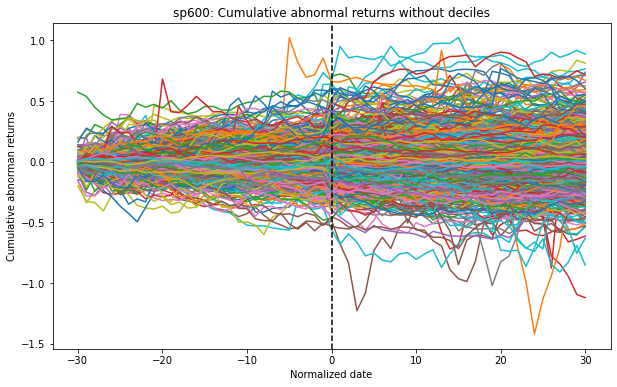

In [12]:
col = list(df_plot)
col.remove('normalized_date')
title = sp+": Cumulative abnormal returns without deciles"
plot = df_plot.plot(x='normalized_date',y=col,figsize=(10,6))
plot.get_legend().remove()
plt.axvline(x=0,color="black",linestyle="--")
plt.xlabel("Normalized date")
plt.ylabel("Cumulative abnorman returns")
plt.title(title)
plt.savefig(title)

In [13]:
#score_method = 'FiGAS' #figas or finbert
#content = 'text'  # 'text' or 'corpus'
#score = 'sent_score' # 'sent_score' or 'sent_score_rough'

In [14]:
def plot_with_deciles(col,score_method,content,score):
    file = "data/sentiment_score/"+score_method+"/"+score_method+ "_" + sp +"_by_"+content +"_final.csv"  #### CHANGE
    merged = []

    # Create score dataframe
    sentiment_text = pd.read_csv(file)  
    sentiment_text = sentiment_text.drop(columns = ['Unnamed: 0'])
    sentiment_text['id'] = sentiment_text['id'].map(str)

    # Get the ids of dataframe col
    col_id = pd.DataFrame(col, columns =['id'])

    # Merge
    merged = pd.merge(col_id, sentiment_text, on='id')
    merged = merged.sort_values(by=['sent_score'])

    # Create deciles
    merged['decile'] = 1 + merged['sent_score'].transform(lambda y:pd.qcut(y,10,labels=False))

    # Compute abnormal returns for each decile
    df_decile_plot = []
    df_decile_plot = pd.DataFrame(data={'normalized_date': np.arange(-number_days_start , number_days_end+1, 1, dtype=int)})

    for i in range(1,11):
        dec1 = merged.loc[merged['decile'].isin([i])]
        long1 = dec1.id
        long1 = long1.to_list()

        df_mean = df_plot[long1].mean(axis=1)
        df_decile_plot['decile'+str(i)]=df_mean

    # Plot
    col = list(df_decile_plot)
    col.remove('normalized_date')
    title = sp+": Cumulative abnormal returns based on " +score_method+ " score (using "+ content + " and "+ score+")"
    plot = df_decile_plot.plot(x='normalized_date',y=col,figsize=(10,6))
    plt.axvline(x=0,color="black",linestyle="--")
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.xlabel("Normalized date")
    plt.ylabel("Cumulative abnorman returns")
    plt.title(title)
    plt.savefig(title)

# Figas

## sent_score

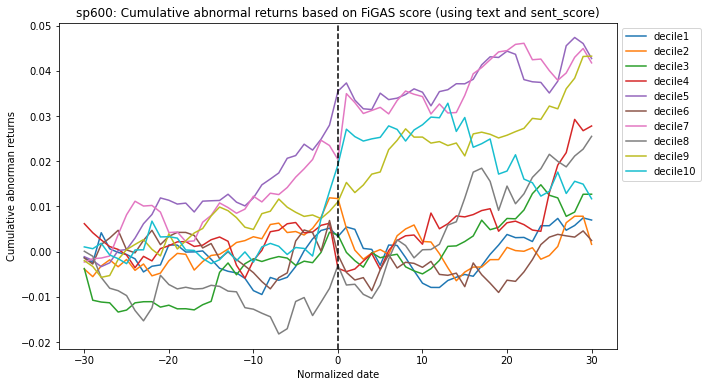

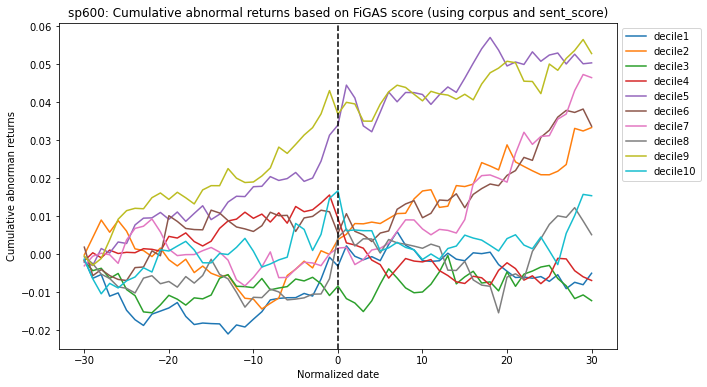

In [15]:
plot_with_deciles(col,'FiGAS','text','sent_score')
plot_with_deciles(col,'FiGAS','corpus','sent_score')

## sent_score_rough

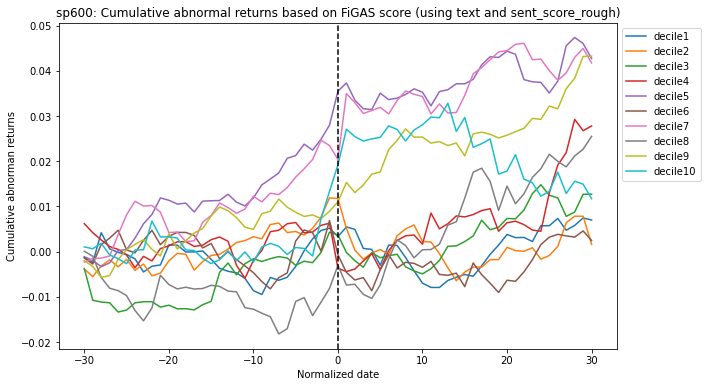

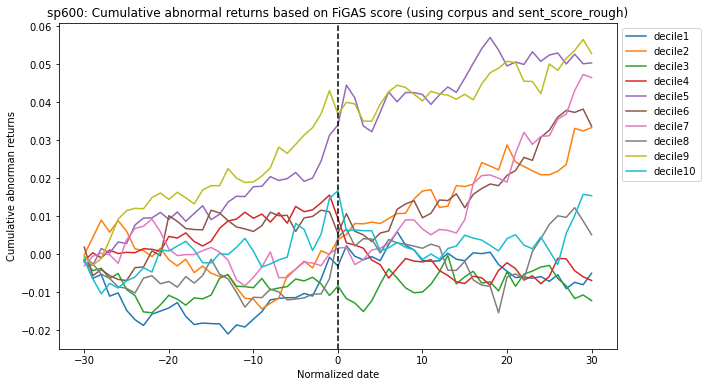

In [16]:
plot_with_deciles(col,'FiGAS','text','sent_score_rough')
plot_with_deciles(col,'FiGAS','corpus','sent_score_rough')